In [1]:
from sklearn.model_selection import (
    train_test_split, GridSearchCV
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes

import numpy as np

diabetes = load_diabetes()
X, y = (diabetes[key] for key in ('data', 'target'))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.10
)

In [2]:
tuned_params = {
    'criterion': ['mse', 'mae'],
    'splitter': ['best', 'random'],
    #'max_features': np.arange(1, 11),
    'max_depth': np.arange(1, 16),
    #'min_samples_split': np.arange(2, 16),
    #'min_samples_leaf': np.arange(1, 16)
}
clf = GridSearchCV(
    DecisionTreeRegressor(),
    tuned_params,
    cv=5,
    n_jobs=4
)
clf.fit(X_train, y_train);

In [3]:
clf.best_params_

{'criterion': 'mse', 'max_depth': 2, 'splitter': 'best'}

In [4]:
clf.best_score_

0.31385572167793596

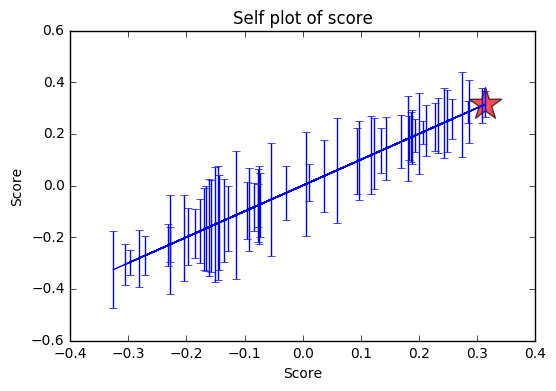

In [5]:
from matplotlib import pyplot as plt
% matplotlib inline

plt.errorbar(
    clf.cv_results_['mean_test_score'],
    clf.cv_results_['mean_test_score'],
    #marker='o',
    yerr=clf.cv_results_['std_test_score']
)
plt.scatter(
    np.max(clf.cv_results_['mean_test_score']),
    np.max(clf.cv_results_['mean_test_score']),
    c='r', marker='*', s=600, alpha=0.7
)
plt.title('Self plot of score')
plt.xlabel('Score')
plt.ylabel('Score')
None

In [6]:
from theano import tensor as T
import theano

y_true = T.vector()
y_pred = T.vector()
mse = ((y_true - y_pred) ** 2).mean()
mse_fun = theano.function(
    [y_pred, y_true],
    mse
)

def mse_const(gamma, y_true):
    return mse_fun(
        np.ones_like(y_true) * gamma,
        y_true
    )

Mean of the targets minimises the MSE.


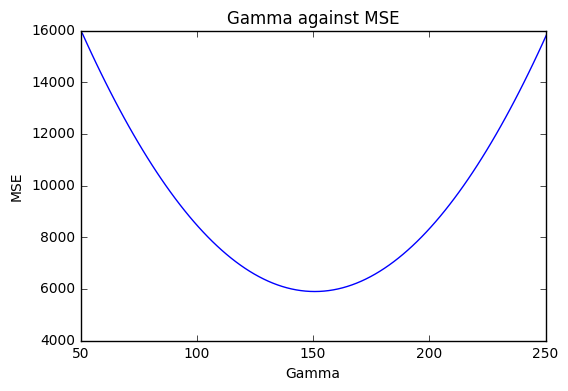

In [7]:
tests = np.zeros(101)
offsets = np.linspace(-100, 100, 101)

for idx, offset in enumerate(offsets):
    tests[idx] = mse_const(
        np.mean(y_train) + offset,
        y_train
    )
plt.plot(np.mean(y_train) + offsets, tests)
plt.xlim([50, 250])
plt.title('Gamma against MSE')
plt.xlabel('Gamma')
plt.ylabel('MSE');
print('Mean of the targets minimises the MSE.')

def f_zero(x, gamma=np.mean(y_train)):
    return np.ones(x.shape[0]) * gamma

models = [f_zero]
coeffs = [1.]

In [8]:
residuals = -T.grad(
    mse, y_pred
)
res_fun = theano.function(
    [y_pred, y_true],
    residuals
)

In [9]:
res_vals = res_fun(f_zero(X_train), y_train)

In [10]:
f_1 = DecisionTreeRegressor(
    **{
        'criterion': 'mse',
        'max_depth': 2,
        'splitter': 'best'
    }
).fit(X_train, res_vals)

In [11]:
def f_to_min(coeff):
    return mse_fun(
        y_train,
        f_zero(X_train) + coeff * f_1.predict(X_train)
    )

In [12]:
import scipy
new_gamma = scipy.optimize.brent(f_to_min)
models.append(f_1.predict)
coeffs.append(new_gamma)

In [13]:
print(
    'Baseline was {:.3f}\n'
    '0-round gradient boosting was {:.3f}\n'
    '1-round gradient boosting was {:.3f}'.format(
        float(mse_fun(y_train, clf.predict(X_train))),
        float(mse_fun(y_train, f_zero(X_train))),
        float(f_to_min(198.5))
    )
)

Baseline was 3344.126
0-round gradient boosting was 5896.073
1-round gradient boosting was 3344.126


In [14]:
pred_all = [models[i](X_train) * coeffs[i] for i in range(len(models))]

In [28]:
pred_ens = np.mean(np.vstack(pred), axis=0)

In [30]:
res_2 = res_fun(pred_ens, y_train)
f_2 = DecisionTreeRegressor(
    **{
        'criterion': 'mse',
        'max_depth': 2,
        'splitter': 'best'
    }
).fit(X_train, res_2)
def f_to_min(coeff):
    return mse_fun(
        y_train,
        pred_ens + coeff * f_2.predict(X_train)
    )
new_gamma = scipy.optimize.brent(f_to_min)

In [33]:
new_gamma

198.5000000000241

In [34]:
mse_fun(y_train, pred_ens + 198.5 * f_2.predict(X_train))

array(2958.3484694947233)